# Neo export

Cleo allows you to export data from the whole {class}`~cleo.CLSimulator` or from individual {class}`~cleo.InterfaceDevice`s objects to [Neo](https://neo.readthedocs.io/en/latest/) objects.
This facilitates data analysis and visualization with [packages that take Neo as an input format](https://neo.readthedocs.io/en/latest/neo_users.html), as well as export to various [open](https://neo.readthedocs.io/en/latest/share_data.html) and [proprietary](https://neo.readthedocs.io/en/latest/iolist.html) ephys data file formats, which could be useful for integration with existing pipelines developed for experimental data.

## Setup

In [ ]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, ephys, light
import neo

import cleo.utilities

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = "numpy"
# for reproducibility
np.random.seed(18060520)
cleo.utilities.set_seed(18060520)
b2.seed(18730508)

cleo.utilities.style_plots_for_docs()

We'll set up a basic simulation to see how export works for different devices and the whole simulation.

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x [um]', ylabel='y [um]', zlabel='z [um]'>)

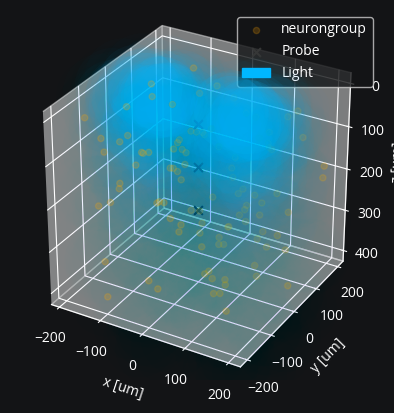

In [ ]:
ng = b2.NeuronGroup(
    100,
    """dv/dt = ((-70*mV - v) + (500*Mohm)*Iopto) / (20*ms) : volt
    Iopto : amp""",
    threshold="v > -50*mV",
    reset="v = -70*mV",
)
ng.v = -70 * b2.mV
syn = b2.Synapses(ng, on_pre="v += 3*mV")
cleo.coords.assign_coords_rand_rect_prism(ng, (-0.2, 0.2), (-0.2, 0.2), (0, 0.4))

light = light.Light(
    coords=[[-0.1, 0, 0], [0.1, 0, 0]] * b2.mm, light_model=light.fiber473nm()
)
probe = ephys.Probe(
    coords=[[0, 0, 50], [0, 0, 150], [0, 0, 250]] * b2.um,
    signals=[
        ephys.TKLFPSignal(),
        ephys.MultiUnitSpiking(
            r_perfect_detection=50 * b2.um, r_half_detection=100 * b2.um
        ),
        ephys.SortedSpiking(
            r_perfect_detection=50 * b2.um, r_half_detection=100 * b2.um
        ),
    ],
)
sim = cleo.CLSimulator(b2.Network(ng))


class IOProc(cleo.ioproc.LatencyIOProcessor):
    def process(self, state_dict, t_samp_ms):
        return {"Light": 0.5 * np.random.rand(light.n) * b2.mwatt / b2.mm2}, t_samp_ms


sim.set_io_processor(IOProc(sample_period=1 * b2.ms))
sim.inject(light, ng).inject(probe, ng, tklfp_type="exc")
sim.inject(opto.chr2_4s(), ng)

cleo.viz.plot(ng, colors=["orange"], sim=sim)

In [ ]:
sim.run(50 * b2.ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.52s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_neurongroup', using method 'euler' (took 0.07s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]


## Exporting individual devices

Depending on whether time values are regularly spaced, data is exported to either {class}`~neo.core.AnalogSignal` or {class}`~neo.core.IrregularlySampledSignal` objects, with appropriate annotations and per-channel annotations.

In [ ]:
light.to_neo()

IrregularlySampledSignal with 2 channels of length 51; units mW/mm**2; datatype float64 
name: 'Light'
description: 'Exported from Cleo Light device'
annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 347520)}
sample times: [ 0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.] ms

In [ ]:
light.to_neo().array_annotations

{'x': array([-0.1,  0.1]) * mm,
 'y': array([0., 0.]) * mm,
 'z': array([0., 0.]) * mm,
 'direction_x': array([0., 0.]),
 'direction_y': array([0., 0.]),
 'direction_z': array([1., 1.]),
 'i_channel': array([0, 1])}

Different signals from the same device are grouped together:

In [ ]:
probe_neo = probe.to_neo()
probe_neo

Group with 2 groups, 1 analogsignals
name: 'Probe'
description: 'Exported from Cleo Probe device'

In [ ]:
probe_neo.children

(AnalogSignal with 3 channels of length 50; units uV; datatype float64 
 name: 'Probe.TKLFPSignal'
 description: 'Exported from Cleo TKLFPSignal object'
 annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 474501)}
 sampling rate: 1.0 1/ms
 time: 0.0 ms to 50.0 ms,
 Group with 3 spiketrains
 name: 'Probe.MultiUnitSpiking'
 description: 'Exported from Cleo MultiUnitSpiking object'
 annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 479844)},
 Group with 62 spiketrains
 name: 'Probe.SortedSpiking'
 description: 'Exported from Cleo SortedSpiking object'
 annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 579646)})

## Whole-simulation export
Exporting the whole {class}`~cleo.CLSimulator` object generates a {class}`~neo.core.Block` object with a single {class}`~neo.core.Segment` object containing all the data from the simulation.

In [ ]:
sim.to_neo()

Block with 1 segments, 1 groups
description: 'Exported from Cleo simulation'
annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 681890)}
# segments (N=1)
0: Segment with 1 analogsignals, 1 irregularlysampledsignals, 65 spiketrains
   # analogsignals (N=1)
   0: AnalogSignal with 3 channels of length 50; units uV; datatype float64 
      name: 'Probe.TKLFPSignal'
      description: 'Exported from Cleo TKLFPSignal object'
      annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 682650)}
      sampling rate: 1.0 1/ms
      time: 0.0 ms to 50.0 ms

## Trial structure

Using the convention that a {class}`~neo.core.Segment` represents a single "trial," there are a couple ways we can generate trial-structured Neo data:

1. Resetting the simulation and exporting the data from each trial individually, merging them into a single {class}`~neo.core.Block` object.
2. Structuring multiple trials into a single call to {meth}`~cleo.CLSimulator.run` and segmenting the data on export.
   This is not implemented, but could be in the future if there is sufficient demand.

Let's try the first of these options:

In [ ]:
block1 = sim.to_neo()
block1.segments[0].name = "trial 1"
sim.reset()
sim.run(50 * b2.ms)
block2 = sim.to_neo()
block2.segments[0].name = "trial 2"

block = neo.Block()
block.segments.extend(block1.segments)
block.segments.extend(block2.segments)
block.groups.extend(block1.groups)
block.groups.extend(block2.groups)
block

Block with 2 segments, 2 groups
# segments (N=2)
0: Segment with 1 analogsignals, 1 irregularlysampledsignals, 65 spiketrains
   name: 'trial 1'
   # analogsignals (N=1)
   0: AnalogSignal with 3 channels of length 50; units uV; datatype float64 
      name: 'Probe.TKLFPSignal'
      description: 'Exported from Cleo TKLFPSignal object'
      annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 21, 791656)}
      sampling rate: 1.0 1/ms
      time: 0.0 ms to 50.0 ms
1: Segment with 1 analogsignals, 1 irregularlysampledsignals, 61 spiketrains
   name: 'trial 2'
   # analogsignals (N=1)
   0: AnalogSignal with 3 channels of length 50; units uV; datatype float64 
      name: 'Probe.TKLFPSignal'
      description: 'Exported from Cleo TKLFPSignal object'
      annotations: {'export_datetime': datetime.datetime(2024, 9, 17, 18, 58, 23, 422050)}
      sampling rate: 1.0 1/ms
      time: 0.0 ms to 50.0 ms

The more attractive approach suggested by Neo's API of `block1.merge(block2)` does not work, but could potentially be fixed in the future.

## Example analysis use case

Let's try [elephant](https://elephant.readthedocs.io/en/stable/index.html), following their [statistics tutorial](https://elephant.readthedocs.io/en/stable/tutorials/statistics.html#Statistics):

<matplotlib.legend.Legend>

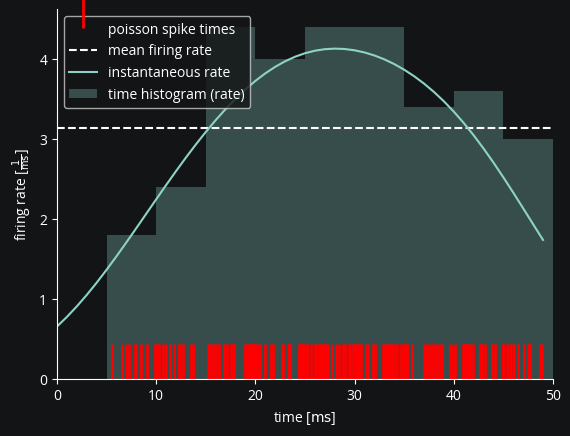

In [ ]:
import matplotlib.pyplot as plt
from elephant.statistics import instantaneous_rate, time_histogram, mean_firing_rate
import quantities as pq

fig, ax = plt.subplots()
st1 = block.segments[0].spiketrains[0]
histogram_rate = time_histogram([st1], 5 * pq.ms, output="rate")
inst_rate = instantaneous_rate(st1, sampling_period=1 * pq.ms)

# plotting the original spiketrain
ax.plot(
    st1,
    [0] * len(st1),
    "r",
    marker=2,
    ms=25,
    markeredgewidth=2,
    lw=0,
    label="poisson spike times",
)

# mean firing rate
ax.hlines(
    mean_firing_rate(st1),
    xmin=st1.t_start,
    xmax=st1.t_stop,
    linestyle="--",
    label="mean firing rate",
)

# time histogram
ax.bar(
    histogram_rate.times,
    histogram_rate.magnitude.flatten(),
    width=histogram_rate.sampling_period,
    align="edge",
    alpha=0.3,
    label="time histogram (rate)",
)

# instantaneous rate
ax.plot(
    inst_rate.times.rescale(pq.ms),
    inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(),
    label="instantaneous rate",
)

# axis labels and legend
ax.set(
    xlabel=f"time [{st1.times.dimensionality.latex}]",
    ylabel=f"firing rate [{histogram_rate.dimensionality.latex}]",
    xlim=(st1.t_start, st1.t_stop),
)
ax.legend()